Through Arima model, the number of people in Azerbaijan is forecasted for the next 7 years with the dataset.


dataset: https://www.macrotrends.net/countries/AZE/azerbaijan/population#:~:text=The%20population%20of%20Azerbaijan%20in,a%200.79%25%20increase%20from%202018

# Import Libaries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.gofplots import qqplot



# Import Dataset

In [2]:
data=pd.read_excel("/content/Population_76.xlsx")

# Data Understanding

In [3]:
# check first 5 rows
data.head()

,Year,Population
0,2022.0,10358074.0
1,2021.0,10312992.0
2,2020.0,10284951.0
3,2019.0,10232753.0
4,2018.0,10152522.0


In [4]:
# check size of dataset
data.shape

(73, 2)

In [5]:
#check null values
data.isnull().sum()

Year          0
Population    0
dtype: int64

In [6]:
#check data types
data.dtypes

Year          float64
Population    float64
dtype: object

In [7]:
# change year column type into date
data.Year=data.Year.astype(int).astype(str) + '-01-01'
data.Year=pd.to_datetime(data.Year)

In [8]:
# sort values by ascending
data.sort_values(by='Year', ascending=True, inplace=True)
data.head()

,Year,Population
72,1950-01-01,3158966.0
71,1951-01-01,3225280.0
70,1952-01-01,3296850.0
69,1953-01-01,3374174.0
68,1954-01-01,3458184.0


In [9]:
# see statistics properties
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Population,73.0,6.892943e+06,2.148478e+06,3158966.0,5207417.0,7009127.0,8556164.0,10358074.0


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


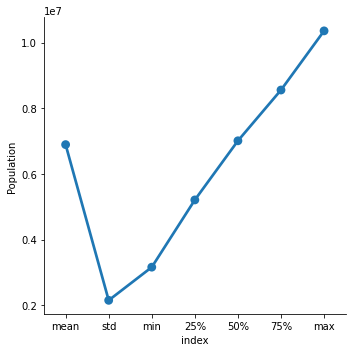

In [53]:
# Visualize Descriptive Statistics

# get numeric columns
num_col = data._get_numeric_data().columns

describe_num_df = data.describe(include=['int64','float64'])
describe_num_df.reset_index(inplace=True)
# To remove any variable from plot
describe_num_df = describe_num_df[describe_num_df['index'] != 'count']
for i in num_col:
  if i in ['index']:
    continue
  sns.factorplot(x='index', y=i, data=describe_num_df)
  plt.show()

In [54]:
# make Year column index 
data.set_index('Year', drop=True, inplace=True)

Text(0.5, 1.0, 'Azerbaijani Population over Years')

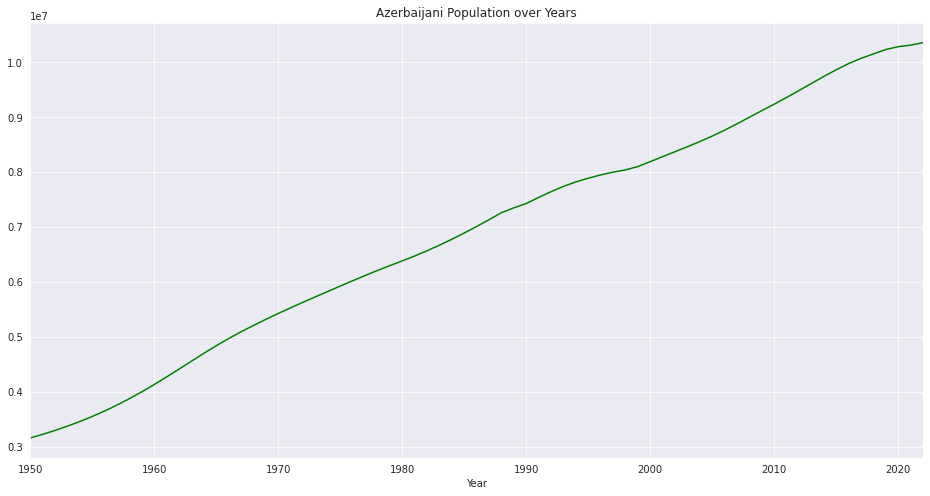

In [55]:
#Visualize Population column
sns.set_style('darkgrid')
data.Population.plot(color='green', figsize=(16, 8))
plt.title('Azerbaijani Population over Years')

# Decompasition

<Figure size 432x288 with 0 Axes>

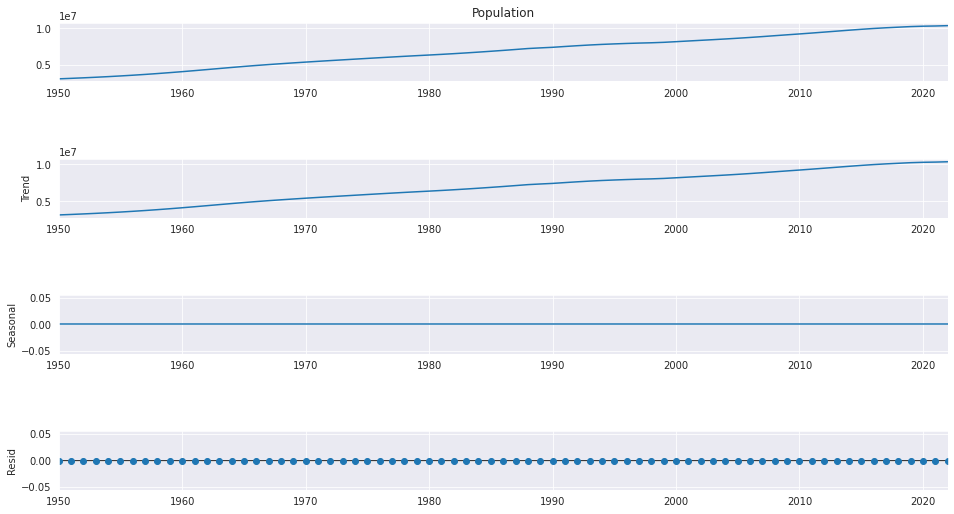

In [57]:
decomposition=seasonal_decompose(data['Population'])
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

From the graph we can see that the entire series is taken as the trend component and that there is no seasonality. We can also see that the residual plot shows around zero.

# Testing for Stationarity

In [ ]:
result = adfuller(data['Population'])
print('ADF test statistic:', result[0]),
print('p value:', result[1])
print('Critical Values:', result[4])


ADF test statistic: -2.4395136674477924
p value: 0.1308930435537135
Critical Values: {'1%': -3.540522678829176, '5%': -2.9094272025108254, '10%': -2.5923136524453696}


In [ ]:
# KPSS Test
result_kpss = kpss(data.Population)
print('KPSS Statistic:', result_kpss[0]),
print('p-value:', result[1]),
print('Critical Values:', result[4])


KPSS Statistic: 0.6805369493068826
p-value: 0.1308930435537135
Critical Values: {'1%': -3.540522678829176, '5%': -2.9094272025108254, '10%': -2.5923136524453696}


According to the results of Adfuller and KPSS tests, given the p values that are more than 0.05, we fail to reject Null Hypothesis that is data is non-stationary. It needs transformation.

In [65]:
# transform the data
adfuller_diff = np.diff(data['Population'], n=1)

ad_fuller_result = adfuller(adfuller_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.0960102540307446
p-value: 0.02684985993161801


# Autocorrelation

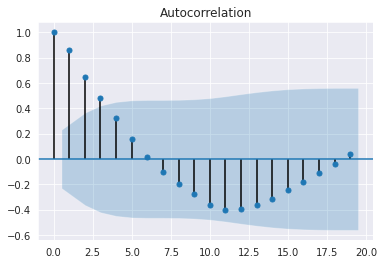

In [58]:
fig = plot_acf(data['Population'].diff().dropna())

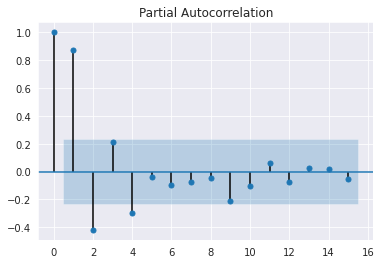

In [59]:
fig = plot_pacf(data['Population'].diff().dropna(), lags=15)

Main priority here is to try to figure out whether will be used the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. While building the model I will use AR(2).

"If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms".

### Figure out Order for Arima

In [60]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [61]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 9.9 MB 42.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [62]:
#import Library for auto_arima
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [66]:
# With Auto Arima check p, d, q
order= auto_arima(data, 
                          suppress_warnings=True)           
order.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -831.658
Date:                Tue, 22 Nov 2022   AIC                           1667.315
Time:                        08:41:52   BIC                           1671.869
Sample:                    01-01-1950   HQIC                          1669.128
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.999e+04   3203.581     31.211      0.000    9.37e+04    1.06e+05
sigma2      6.316e+08   1.11e+08      5.715      0.000    4.15e+08    8.48e+08
===================================================================================
Ljung-Box (L1) (Q):                  55.89   Jarque-Bera (JB):                 3.75
Prob(Q):                              0.00   Prob(JB):                         0.15
Heteroskedasticity (H):               1.19   Skew:                            -0.56
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

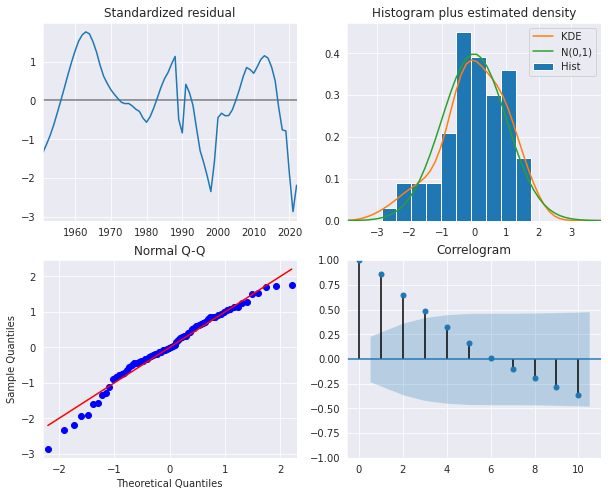

In [ ]:
fig = order.plot_diagnostics(figsize=(10,8))

According to the graph and Ljung-Box test, we reject to Null Hypothesis that residuals are uncorrelated. That's why I'll not be able to use this model.

# Data Splitting

In [67]:
# split data as train and test
train=data[:60]
test=data[60:]


In [68]:
#check size of train dataset
train.shape

(60, 1)

In [69]:
# check size test dataset
test.shape

(13, 1)

In [71]:
# build model with p=2, q=1, m=0
model_arima=ARIMA(train, order=(2, 1, 0))
model_arima_fit=model_arima.fit()

In [72]:
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Population   No. Observations:                   59
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -622.678
Method:                       css-mle   S.D. of innovations           9115.933
Date:                Tue, 22 Nov 2022   AIC                           1253.356
Time:                        09:01:42   BIC                           1261.666
Sample:                    01-01-1951   HQIC                          1256.600
                         - 01-01-2009                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9.949e+04   8338.492     11.931      0.000    8.31e+04    1.16e+05
ar.L1.D.Population     1.2574      0.118     10.653      0.000       1.026       1.489
ar.L2.D.Population  

I will also run the model diagnostics to check for the assumptions Normality of errors and the distribution of residuals. So the errors are should be normally distributed and uncorrelated to each other.

In [77]:
# check residuals 
residuals = model_arima_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

,lb_stat,lb_pvalue
1,0.088611,0.765950
2,3.248106,0.197098
3,4.683268,0.196514
4,4.710758,0.318283
5,4.741933,0.448180
6,4.753533,0.575791
7,5.753101,0.568856
8,5.924100,0.655734
9,7.252225,0.610877
10,11.405742,0.326792


As p-value is more than 0.05, we fail to reject Null Hyphotesis that residuals are uncorrolated

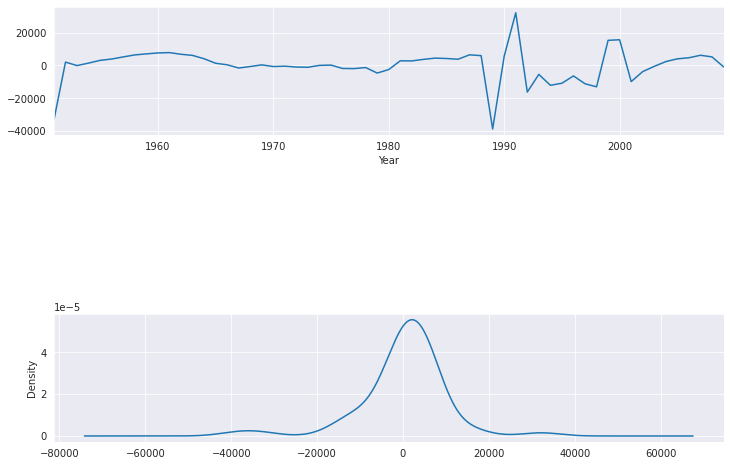

In [82]:
#  visualize residuals distribution
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
model_arima_fit.resid.plot()

plt.subplot(3, 1, 3)
model_arima_fit.resid.plot(kind='kde')

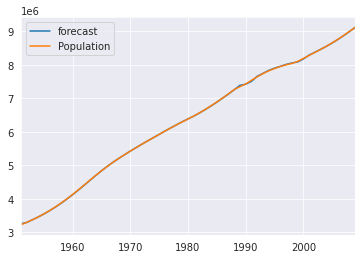

In [84]:
# predict train dataset
model_arima_fit.plot_predict(dynamic=False)
plt.show()

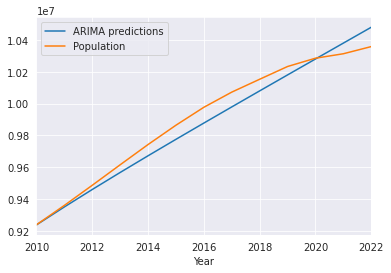

In [85]:
# check the model with test dataset
start=len(train)
end=len(train)+len(test)-1
pred=model_arima_fit.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
data["Prediction"]=model_arima_fit.predict(start=start,end=end,typ='levels')
pred.plot(legend=True)
test['Population'].plot(legend=True)


In [86]:
data.tail(13)

,Population,Prediction
Year,,
2010-01-01,9237202.0,9.236264e+06
2011-01-01,9359014.0,9.349287e+06
2012-01-01,9485576.0,9.459062e+06
2013-01-01,9614478.0,9.566170e+06
2014-01-01,9741880.0,9.671200e+06
2015-01-01,9863480.0,9.774666e+06
2016-01-01,9976248.0,9.876979e+06
2017-01-01,10071567.0,9.978457e+06
2018-01-01,10152522.0,1.007934e+07


In [87]:
#  check measure of prediction accuracy with mean absolute percentage error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
mape=sqrt(mean_absolute_percentage_error(test['Population'], pred))
print(mape)

0.07621708348763463


# Forecasting

In [88]:
# fit the model
model2=ARIMA(data['Population'],order=(2,1,0))
model2=model2.fit()

In [89]:
#forecast next 7 years
forecast=model2.predict(start=len(data), end=len(data)+7,typ='levels').rename('Forecasting')
#print(comp_pred)

print(forecast)

2023-01-01    1.041734e+07
2024-01-01    1.048768e+07
2025-01-01    1.056630e+07
2026-01-01    1.065087e+07
2027-01-01    1.073962e+07
2028-01-01    1.083121e+07
2029-01-01    1.092469e+07
2030-01-01    1.101941e+07
Freq: AS-JAN, Name: Forecasting, dtype: float64


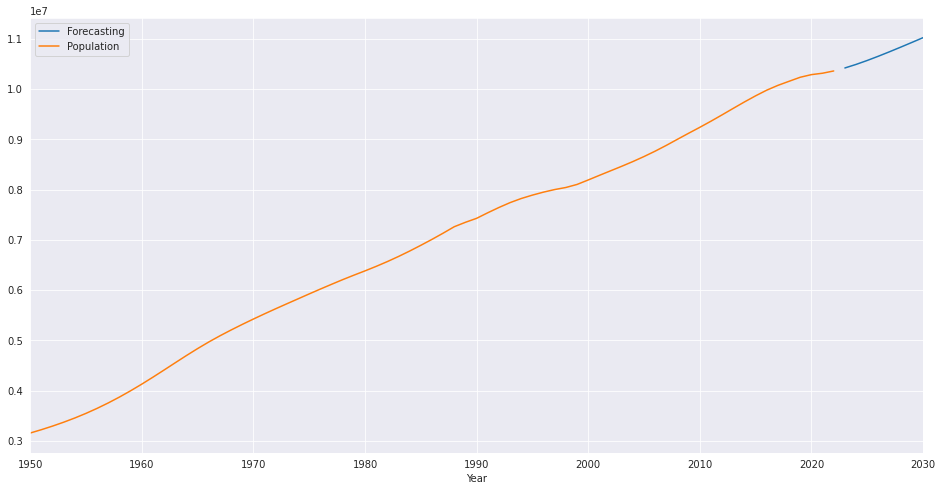

In [90]:
# Visualize the result of the forecast
plt.figure(figsize=(16, 8))
forecast.plot(legend=True)
data['Population'].plot(legend=True)
